# Sampling bias correction for TV viewership data 


# Introduction

Consider a universe of television-watching individuals, denoted by the set U. We have access to data
on the individual viewership behavior of a subset of U, denoted by Us. The Us is known to be a
biased sampling of U; specifically, certain demographic categories are over or under_represented in
the sampled dataset with respect to the national population. We would like to model and forecast the
viewership activity of U using our information on the members of Us. Consequently, the bias in Us
must be measured and compensated for.

**The Challenge**

**In this problem we have two data sets that requires sampling bias correction in a realistic set of TV viewer data**

**`demographic attributes.csv' : This table is derived from a dataset on national TV viewers;
it associates 400,000 person ids with demographic categories to which the person belongs.**

**`demo ground truth.csv' : This table contains census-derived values for the number of individuals belonging to each of the demographic categories in `demographic attributes.csv'. The categories are of three types: age, ethnicity, and education level.**

**I would like to devise an approach to balance the sampled dataset of people in demographic attributes.csv on each demographic category; i.e., the goal here is to compute a set of person{level weights (one single weight per person) that unbiases the dataset.**

In [1]:
#First lets import some basic and useful python library and look into the data
import pandas as pd
import scipy
import IPython
import numpy as np
from matplotlib import style
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#For visualizing bigger dataFrames
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

**Lets read in the data and take a quick look.**

In [3]:
# Now lets import the given datasets, first demographic attributes
df_attr=pd.read_csv('demographic_attributes.csv')
print(df_attr.shape)
df_attr.head()

(400000, 4)


,person id,age,education,ethnicity
0,0,75_84,Some College,white
1,1,85_120,HS Diploma,white
2,2,25_34,Some College,white
3,3,55_64,HS Diploma,black
4,4,45_54,Bachelor Degree,white


In [4]:
df_attr.dtypes

person id     int64
age          object
education    object
ethnicity    object
dtype: object

In [5]:
df_attr.describe(include='all')

,person id,age,education,ethnicity
count,400000.000000,400000,377810,400000
unique,NaN,8,5,5
top,NaN,55_64,HS Diploma,white
freq,NaN,104788,111113,307668
mean,199999.500000,NaN,NaN,NaN
std,115470.198175,NaN,NaN,NaN
min,0.000000,NaN,NaN,NaN
25%,99999.750000,NaN,NaN,NaN
50%,199999.500000,NaN,NaN,NaN
75%,299999.250000,NaN,NaN,NaN


**we can see there are missing values for the education categories. I will fill those null values with the mode method.**

In [6]:
#lets find the null values in these categorical data and impute them with mode(max frequency)methos
max_freq = df_attr['education'].value_counts().index[0]
df_attr['education'][pd.isna(df_attr['education'])] = max_freq


<ipython-input-6-6daca4d9b5d5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_attr['education'][pd.isna(df_attr['education'])] = max_freq


In [7]:
df_attr.describe(include='all')

,person id,age,education,ethnicity
count,400000.000000,400000,400000,400000
unique,NaN,8,5,5
top,NaN,55_64,HS Diploma,white
freq,NaN,104788,133303,307668
mean,199999.500000,NaN,NaN,NaN
std,115470.198175,NaN,NaN,NaN
min,0.000000,NaN,NaN,NaN
25%,99999.750000,NaN,NaN,NaN
50%,199999.500000,NaN,NaN,NaN
75%,299999.250000,NaN,NaN,NaN


**Now I want to look on the second data table the ground Truth.**

In [8]:
# Now lets import the demo graound truth data
df_gt=pd.read_csv('demo_ground_truth_csv.csv')
print(df_gt.shape)
df_gt.head()

(22, 2)


,demographic category,number of individuals
0,18_24,11839159
1,25_34,16399632
2,35_44,15335704
3,45_54,16430762
4,55_64,15148777


In [9]:
# lets find some more information 
for col in df_attr.columns[0:]:
    print(col,': ', len(df_attr[col].unique()),'labels')

person id :  400000 labels
age :  8 labels
education :  5 labels
ethnicity :  5 labels


In [10]:
df_attr.describe(include='all')

,person id,age,education,ethnicity
count,400000.000000,400000,400000,400000
unique,NaN,8,5,5
top,NaN,55_64,HS Diploma,white
freq,NaN,104788,133303,307668
mean,199999.500000,NaN,NaN,NaN
std,115470.198175,NaN,NaN,NaN
min,0.000000,NaN,NaN,NaN
25%,99999.750000,NaN,NaN,NaN
50%,199999.500000,NaN,NaN,NaN
75%,299999.250000,NaN,NaN,NaN


**Now lets plot the histogram for each of the categories.**

C:\Users\MK\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


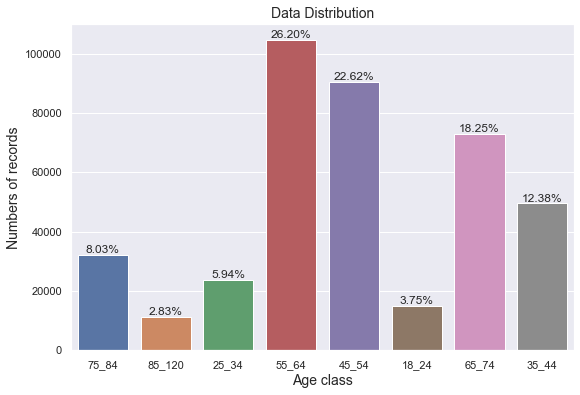

In [11]:
# Graphical representation by age group.
total_len = len(df_attr['age'])
sns.set(rc={'figure.figsize':(9,6)})
sns.countplot(df_attr['age']).set_title('Data Distribution', fontsize=14)
ax = plt.gca()
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
            height + 2,
            '{:.2f}%'.format(100*(height/total_len)),
            fontsize=12, ha='center', va='bottom')
sns.set(font_scale=2)
ax.set_xlabel("Age class", fontsize=14)
ax.set_ylabel("Numbers of records", fontsize=14)
plt.show()

C:\Users\MK\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


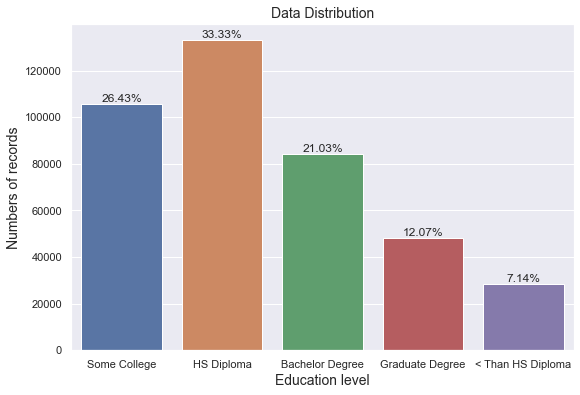

In [368]:
# Graphical representation by age group.
total_len = len(df_attr['education'])
sns.set(rc={'figure.figsize':(9,6)})
sns.countplot(df_attr['education']).set_title('Data Distribution', fontsize=14)
ax = plt.gca()
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
            height + 2,
            '{:.2f}%'.format(100*(height/total_len)),
            fontsize=12, ha='center', va='bottom')
sns.set(font_scale=2)
ax.set_xlabel("Education level", fontsize=14)
ax.set_ylabel("Numbers of records", fontsize=14)
plt.show()

C:\Users\MK\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


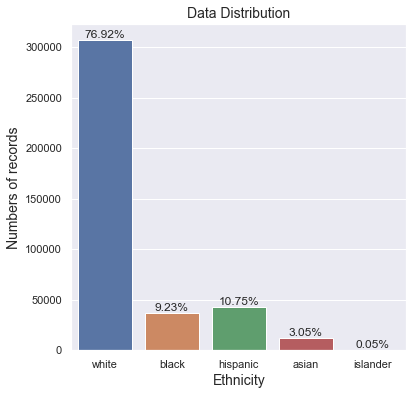

In [12]:
# Graphical representation by ethnicity.
total_len = len(df_attr['ethnicity'])
sns.set(rc={'figure.figsize':(6,6)})
sns.countplot(df_attr['ethnicity']).set_title('Data Distribution', fontsize=14)
ax = plt.gca()
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
            height + 2,
            '{:.2f}%'.format(100*(height/total_len)),
            fontsize=12, ha='center', va='bottom')
sns.set(font_scale=2)
ax.set_xlabel("Ethnicity", fontsize=14)
ax.set_ylabel("Numbers of records", fontsize=14)
plt.show()

**Based on above histograms we can clearly see that the data is highly baised based on ethnicity. Amlost 77% of the population sampled are white. In education categories people with no high school diploma and with graduate degree are undersampled. On the Age group also, the data is baised against the population with age group of 18-24 and 25-34.
Now we need to deal with this sampling bias.**

**Before that I want to see what percentage of population in the US census data fall in these various categories. So lets find percentage and ratio distribution of these categories in the Census data.**

In [13]:
# Now I want to use the `demo ground truth' df_gt data and analyze the percentage distributions for each categories. 
df_gt['Percentage'] = 100 * df_gt['number of individuals']  / df_gt['number of individuals'].sum()
df_gt['Percentage']=round(df_gt['Percentage'], 2)
df_gt['ratio']=df_gt['Percentage']/100
print(df_gt.shape)
print(df_gt)

(22, 4)
   demographic category  number of individuals  Percentage   ratio
0                 18_24               11839159        3.59  0.0359
1                 25_34               16399632        4.97  0.0497
2                 35_44               15335704        4.65  0.0465
3                 45_54               16430762        4.98  0.0498
4                 55_64               15148777        4.59  0.0459
5                 65_74                9990412        3.03  0.0303
6                 75_84                5221430        1.58  0.0158
7                   0_4                7500407        2.27  0.0227
8                   5_9                7748669        2.35  0.0235
9                 10_14                7815759        2.37  0.0237
10                15_17                4758751        1.44  0.0144
11               85_120                2293226        0.70  0.0070
12    < Than HS Diploma               12274025        3.72  0.0372
13      Bachelor Degree               16305721        

**Based on this results we can see that among 22 demographic categories, white is highly over sampled. Islander category is undersampled. some age group categories are also bais.**

**Now a major question that arise from this observation is what is the ratio of people that are in this multiple categories? Eg. what percentage of white people are in age between 25-34 and have garduate degree? or what percentage of Asian have bachelor degree and are in age range of 45-54? and how do we define the weight for these individuals? This will make this problem interestnig but complicated. I will take a simpler approach rather than spending more time on this.
So I am taking a simple steps here. I will design weights for each category separetely for each individuals and then average the weights out to find weights for each individuals.**

In [14]:
#lets tart with age categories. There are 8 categories in the age.
df_attr.age.value_counts()

55_64     104788
45_54      90479
65_74      73018
35_44      49527
75_84      32107
25_34      23751
18_24      15000
85_120     11330
Name: age, dtype: int64

In [15]:
print(df_gt)

   demographic category  number of individuals  Percentage   ratio
0                 18_24               11839159        3.59  0.0359
1                 25_34               16399632        4.97  0.0497
2                 35_44               15335704        4.65  0.0465
3                 45_54               16430762        4.98  0.0498
4                 55_64               15148777        4.59  0.0459
5                 65_74                9990412        3.03  0.0303
6                 75_84                5221430        1.58  0.0158
7                   0_4                7500407        2.27  0.0227
8                   5_9                7748669        2.35  0.0235
9                 10_14                7815759        2.37  0.0237
10                15_17                4758751        1.44  0.0144
11               85_120                2293226        0.70  0.0070
12    < Than HS Diploma               12274025        3.72  0.0372
13      Bachelor Degree               16305721        4.94  0.

**To average the bais of the 8 different age categories, the polulation should be divided into 1/8 which is 0.125. 
So I am going to assign the weight of 0.125 for each of the categories.
But this does not make sense of the real polulation data and its ratio given with census data in ground truth files. To overcome this problem, the raio for each categories from the Census ground truth data will be multiplied with the types age categories and its factor of 0.125**

In [16]:
df_attr.loc[df_attr['age'] == '55_64', 'age_wt'] = df_gt.iloc[4]['ratio']*0.125
df_attr.loc[df_attr['age'] == '45_54', 'age_wt'] = df_gt.iloc[3]['ratio']*0.125
df_attr.loc[df_attr['age'] == '65_74', 'age_wt'] = df_gt.iloc[5]['ratio']*0.125
df_attr.loc[df_attr['age'] == '35_44', 'age_wt'] = df_gt.iloc[2]['ratio']*0.125
df_attr.loc[df_attr['age'] == '75_84', 'age_wt'] = df_gt.iloc[6]['ratio']*0.125
df_attr.loc[df_attr['age'] == '25_34', 'age_wt'] = df_gt.iloc[1]['ratio']*0.125
df_attr.loc[df_attr['age'] == '18_24', 'age_wt'] = df_gt.iloc[0]['ratio']*0.125
df_attr.loc[df_attr['age'] == '85_120', 'age_wt'] = df_gt.iloc[11]['ratio']*0.125
df_attr.head(10)

,person id,age,education,ethnicity,age_wt
0,0,75_84,Some College,white,0.001975
1,1,85_120,HS Diploma,white,0.000875
2,2,25_34,Some College,white,0.006212
3,3,55_64,HS Diploma,black,0.005737
4,4,45_54,Bachelor Degree,white,0.006225
5,5,25_34,HS Diploma,white,0.006212
6,6,55_64,Some College,white,0.005737
7,7,45_54,HS Diploma,white,0.006225
8,8,18_24,Some College,white,0.004488
9,9,75_84,Some College,white,0.001975


**Next categories I am going to look at is Education. there are 5 education categories. If we want to sample them equally, we want to make them 1/5 which is 0.2.**

**But this does not make sense of the real polulation data and its ratio given with census data in ground truth files. To overcome this problem, the raio for each categories from the Census ground truth data will be multiplied with the types age categories and its factor of 0.2**

In [17]:
#lets look and work with education categories.
df_attr.education.value_counts()

HS Diploma           133303
Some College         105725
Bachelor Degree       84114
Graduate Degree       48289
< Than HS Diploma     28569
Name: education, dtype: int64

In [18]:
df_attr.loc[df_attr['education'] == 'HS Diploma', 'education_wt'] = df_gt.iloc[15]['ratio']*0.2
df_attr.loc[df_attr['education'] == 'Some College', 'education_wt'] =df_gt.iloc[16]['ratio']* 0.2
df_attr.loc[df_attr['education'] == 'Bachelor Degree', 'education_wt'] =df_gt.iloc[13]['ratio']* 0.2
df_attr.loc[df_attr['education'] == 'Graduate Degree', 'education_wt'] = df_gt.iloc[14]['ratio']*0.2
df_attr.loc[df_attr['education'] == '< Than HS Diploma', 'education_wt'] = df_gt.iloc[12]['ratio']*0.2
df_attr.head(10)

,person id,age,education,ethnicity,age_wt,education_wt
0,0,75_84,Some College,white,0.001975,0.01754
1,1,85_120,HS Diploma,white,0.000875,0.01564
2,2,25_34,Some College,white,0.006212,0.01754
3,3,55_64,HS Diploma,black,0.005737,0.01564
4,4,45_54,Bachelor Degree,white,0.006225,0.00988
5,5,25_34,HS Diploma,white,0.006212,0.01564
6,6,55_64,Some College,white,0.005737,0.01754
7,7,45_54,HS Diploma,white,0.006225,0.01564
8,8,18_24,Some College,white,0.004488,0.01754
9,9,75_84,Some College,white,0.001975,0.01754


In [19]:
df_attr.education_wt.value_counts()

0.01564    133303
0.01754    105725
0.00988     84114
0.00566     48289
0.00744     28569
Name: education_wt, dtype: int64

**The last category to correct the bias based on ethnicity. There are 5 classes of ethnicity and white category dominates largely. Here I will use the simialr method of weighting as done for above categories.**

**But this does not make sense of the real polulation data and its ratio given with census data in ground truth files. To overcome this problem, the raio for each categories from the Census ground truth data will be multiplied with the types age categories and its factor of 0.2**

In [20]:
df_attr.ethnicity.value_counts()

white       307668
hispanic     42991
black        36940
asian        12213
islander       188
Name: ethnicity, dtype: int64

In [21]:
df_attr.loc[df_attr['ethnicity'] == 'white', 'ethnicity_wt'] = df_gt.iloc[21]['ratio']*0.2
df_attr.loc[df_attr['ethnicity'] == 'hispanic', 'ethnicity_wt'] =df_gt.iloc[19]['ratio']* 0.2
df_attr.loc[df_attr['ethnicity'] == 'black', 'ethnicity_wt'] = df_gt.iloc[18]['ratio']*0.2
df_attr.loc[df_attr['ethnicity'] == 'asian', 'ethnicity_wt'] = df_gt.iloc[17]['ratio']*0.2
df_attr.loc[df_attr['ethnicity'] == 'islander', 'ethnicity_wt'] = df_gt.iloc[20]['ratio']*0.2
df_attr.head(10)

,person id,age,education,ethnicity,age_wt,education_wt,ethnicity_wt
0,0,75_84,Some College,white,0.001975,0.01754,0.04476
1,1,85_120,HS Diploma,white,0.000875,0.01564,0.04476
2,2,25_34,Some College,white,0.006212,0.01754,0.04476
3,3,55_64,HS Diploma,black,0.005737,0.01564,0.00886
4,4,45_54,Bachelor Degree,white,0.006225,0.00988,0.04476
5,5,25_34,HS Diploma,white,0.006212,0.01564,0.04476
6,6,55_64,Some College,white,0.005737,0.01754,0.04476
7,7,45_54,HS Diploma,white,0.006225,0.01564,0.04476
8,8,18_24,Some College,white,0.004488,0.01754,0.04476
9,9,75_84,Some College,white,0.001975,0.01754,0.04476


**Last thing we want to do is average out the three different weights applied to the three categories and find the over all average weights for the personal ids and export the csv file.**

In [22]:
df_attr['average_weight'] = df_attr[['age_wt', 'education_wt', 'ethnicity_wt']].mean(axis=1)
df_attr['average_weight']=round(df_attr['average_weight'], 4)
df_attr.head(10)

,person id,age,education,ethnicity,age_wt,education_wt,ethnicity_wt,average_weight
0,0,75_84,Some College,white,0.001975,0.01754,0.04476,0.0214
1,1,85_120,HS Diploma,white,0.000875,0.01564,0.04476,0.0204
2,2,25_34,Some College,white,0.006212,0.01754,0.04476,0.0228
3,3,55_64,HS Diploma,black,0.005737,0.01564,0.00886,0.0101
4,4,45_54,Bachelor Degree,white,0.006225,0.00988,0.04476,0.0203
5,5,25_34,HS Diploma,white,0.006212,0.01564,0.04476,0.0222
6,6,55_64,Some College,white,0.005737,0.01754,0.04476,0.0227
7,7,45_54,HS Diploma,white,0.006225,0.01564,0.04476,0.0222
8,8,18_24,Some College,white,0.004488,0.01754,0.04476,0.0223
9,9,75_84,Some College,white,0.001975,0.01754,0.04476,0.0214


In [23]:
#now lets export the data out to csv with selected columns
df_attr.to_csv('Murari_Khatiwada_VA_DS_Challange', columns=['person id', 'average_weight'], index=False)

**Done!!**